In [1]:
%pylab inline
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D


Populating the interactive namespace from numpy and matplotlib


### Ecuacion Difusion en Reactor Tubular

Tenemos las ecuaciones que describen el intercambio de calor entre 2 fluidos en un reactor tubular, considerando despreciable el ancho del mismo, de la siguiente manera:


Dado que cr=0 cuando r=0, teneos que crr cuando r tiende a 0 es un límite de la forma 0/0. Así, usamos l'Hopital en ambas ecuaciones por lo que obtenemos que cr/r=crr para r tendiendo a 0 y con Tr=0 en r=0 entonces Trr=Trr.

Caso r 0
ct=−vcz+D(czz+2crr)−r(c,T)
ct=−vTz+λpcpD(Tzz+2Trr)−ΔHpcpr(c,T)

In [2]:
#definicion de constantes, variables y pasos de cada ecuación diferencial
n_x = 10
n_t = 20
L = 30 #esos son los valores que toca ver para un caso determinado
R = 1 # radio reservorio

r = np.linspace(0.1,R,n_x)
z = np.linspace(0.1,L,n_x)

dr = r[1]-r[0]
dz = z[1]-z[0]

#trate de hacer el dt como en la wave equation pero no veo como despejarlo, entonces lo definiremos a ojo
dt = 0.00000000000001
d_H = -525676 #entalpia
C_p = 192.59 #calor especifico
rho = 1040 #densidad
T_w = 100 #temperatura del reservorio
lamda = 200
k_0 = 10
E = 10
D = 10**-9 #difusividad
h = R*3.15


In [3]:
#Funcion r, en este caso no hay cabida 
def rf(c1, T1): 
    if(c1 >= 0 and T1 >= 0):
        return k_0 + np.exp(-E/(R*T1))*(c1**2)
    else:
        return 0

#Funcion v
def v_over_vmax(r1): #funcion normalizada de la velocidad de difusion
    return (1-(r1/R)**2)

In [4]:
T_past = np.ones((n_x, n_x))
#declaramos los arreglos para T y c que guardaran todo de aca e adelante, pero necesitamos los iniciales, entonces:
c_past = np.zeros((n_x, n_x))
T_0 = 20*np.ones((n_x, n_x))#en Celsius, la temperatura inicial comienza a T ambiente
#declaramos que la concentracion empieza con inicial de 10
c_0 = 10*np.ones((n_x, n_x))

for i in range(0,n_x):
    #dependencia de r
    for j in range(0,n_x):
        #dependencia de z
        
        T_0[i,j]=100 + 0.05*i #arbitrariamente elegimos que la temperatura aumente 0.05 grados por iteracion y que no dependa de z
        c_0[i,j]=100 - 0.005*j #arbitrariamente elijo que la concentracion disminuya a medida que atravieza en z

        
#dado que necesitamos inciar el llenado de los arreglos ya con los valores iniciales, llenamos lalista asi como 
#vimos en clase
T_pres = 25*T_0.copy()
c_pres = c_0.copy()

#ahora definimos las condiciones de frontera en cada caso
                        
#f es la funcion que queremos derivar, i es r, j es z. Estas son las primeras derivadas

def derivada1_r(f,i,j):
                
    if(i==len(f)): #cuando R=r
        return (h/lamda)*(Tw - f[i][j])
    #elif(i == 0):
        #return 0
    else:
        return (f[i+1][j]-f[i-1][j])/(2*dr) 
         
    
def derivada1_z(f,i,j):
                
    if(j==len(f)):
        return 0
    #elif(j == 0):
        #return 0
    else:
        return (f[i][j]-f[i][j-1])/(2*dz) 

#f es la funcion que queremos derivar, i es r, j es z. Estas son las segundas derivadas. 
def derivada2_r(f, i, j):
    
    if(i==len(f)): #corregir  esta funcion de mierda
        return (h/lamda)*(Tw - f(i,j))
    #elif(i == 0):
    else:
        return (f[i+1][j] + 2*f[i][j]-f[i-1][j])/(2*dr) 

def derivada2_z(f,i,j):
         
    #if(j == len(f)):
        #return 0
    #elif(j == 0):
        #return 0
    return (f[i][j] + 2*f[i][j-1]-f[i][j-2])/(2*dz)  


In [5]:
#condiciones iniciales antes de correr la iteracion
#cuando r = 0 la derivada vale 0 
#for j in
#c_pres[0,j] = dt*(c_past[0,j]) - v_over_vmax(r[i])*derivada1_z(c_past,0,j)  + D*(derivada2_z(c_past,0,j))- rf(c_past[0,j],T_past[0,j])        


In [6]:
#Discretizacion en el timempo, bellas condiciones de frontera
for t in range(n_t):
    T_past = T_pres.copy() #actualizando el arreglo por eemento para generar el siguiente
    c_past = c_pres.copy()
    for i in range(1,n_x-1):
        for j in range(1,n_x-1): 
            
                #cuando r es cero pasa esto
                c_pres[0,j] = dt*(c_past[0,j]) - v_over_vmax(r[0])*derivada1_z(c_past,0,j)  + D*(derivada2_z(c_past,0,j))- rf(c_past[0,j],T_past[0,j])                                                  
                     
                T_pres[0,j] = dt*(T_past[0,j]) - v_over_vmax(r[0])*derivada1_z(T_past,0,j)  + (lamda/rho*C_p)*(derivada2_z(T_past,0,j))- (d_H/rho*C_p)* rf(c_past[0,j],T_past[0,j])
                # cuando R=r
                c_pres[1,j] = dt*(c_past[1,j]) - v_over_vmax(r[1])*derivada1_z(c_past,1,j)  + D*(derivada2_z(c_past,1,j))- rf(c_past[1,j],T_past[1,j])  
                T_pres[1,j] = (h/lamda)*(T_w - T_pres[1,j])
                #cuando z=L   
                                
                if (i!=0 and i!=1):
                    c_pres[i,j] = dt*(c_past[i,j]) - v_over_vmax(r[i])*derivada1_z(c_past,i,j)  + D*(derivada2_z(c_past,i,j) + derivada2_r(c_past,i,j) + derivada1_r(c_past,i,j)/r[i])- rf(c_past[i,j],T_past[i,j])                    
                    T_pres[i,j] = dt*(T_past[i,j]) - v_over_vmax(r[i])*derivada1_z(T_past,i,j)  + (lamda/rho*C_p)*(derivada2_z(T_past,i,j) + derivada2_r(T_past,i,j) + derivada1_r(T_past,i,j)/r[i])- (d_H/rho*C_p)* rf(c_past[i,j],T_past[i,j])

In [8]:
c_pres
T_pres


array([[  2.50000000e+03,   2.49238490e+05,  -6.40836094e+05,
          3.85335096e+05,   1.14757020e+04,  -6.08316909e+03,
          1.17029300e+03,   9.41859709e+01,  -2.24353418e+01,
          2.50000000e+03],
       [  2.50125000e+03,   1.55057839e+00,   1.55057839e+00,
          1.55057839e+00,   1.55057839e+00,   1.55057839e+00,
          1.55057839e+00,   1.55057839e+00,   1.55057839e+00,
          2.50125000e+03],
       [  2.50250000e+03,   1.99501289e+05,  -5.32125072e+05,
          3.28812713e+05,   7.23625355e+03,  -3.89381611e+03,
          7.73341760e+02,   5.00764117e+01,  -1.26551923e+01,
          2.50250000e+03],
       [  2.50375000e+03,   1.58683083e+05,  -4.41555131e+05,
          2.80503189e+05,   4.71137650e+03,  -2.57167346e+03,
          5.25508935e+02,   2.67382575e+01,  -7.01295331e+00,
          2.50375000e+03],
       [  2.50500000e+03,   1.12770813e+05,  -3.37188616e+05,
          2.23245979e+05,   2.57898011e+03,  -1.43629622e+03,
          3.03652653e+02

In [89]:
 = min(T_pres)
maxi = T_pres.max()

levels = np.linspace(mini, maxi, 10000)

fig, axs = plt.subplots(1,1)
cs = axs.contourf(r, z, T_pres, levels=levels)

fig.colorbar(cs, ax=axs, format="%.3g")

plt.title('Temperatura (K)')
plt.ylabel('Z')
plt.xlabel('R')
plt.savefig('tempertura.png')

print mini, maxi








mini = T_now.min()
maxi = T_now.max()
#Se define el numero de niveles que va a tener el contorno. Para nuestro caso elegimos 100
levels = np.linspace(mini, maxi, 100)



fig, axs = plt.subplots(3,1)
#Se hace el mapeo por el contorno dado
cs = axs[0].contourf(r, z, T_now, levels=levels)
fig.colorbar(cs, ax=axs[0], format="%.1f")
axs[0].set_title('Cambio En Temperatura cada (0.01s) (K)')


c_now, T_now = evolve(n_time,c_now,T_now)
c1 = c_now.copy()
mini = T_now.min()
maxi = T_now.max()
#Se define el numero de niveles que va a tener el contorno. Para nuestro caso elegimos 100
levels = np.linspace(mini, maxi, 100)
cs = axs[1].contourf(r, z, T_now, levels=levels)
fig.colorbar(cs, ax=axs[1], format="%.1f")


c_now, T_now = evolve(n_time,c_now,T_now)
c2 = c_now.copy()
mini = T_now.min()
maxi = T_now.max()
#Se define el numero de niveles que va a tener el contorno. Para nuestro caso elegimos 100
levels = np.linspace(mini, maxi, 100)
cs = axs[2].contourf(r, z, T_now, levels=levels)
fig.colorbar(cs, ax=axs[2], format="%.1f")

#Se añade barra de color
#fig[1].colorbar(cs, ax=axs, format="%.3g")


plt.ylabel('Z')
plt.xlabel('R')
plt.savefig('tempertura.png')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(-12.039701312379792, 100.0)

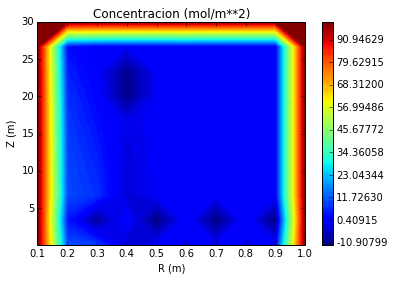

In [9]:

mini = c_pres.min()
maxi = c_pres.max()
#Se define el numero de niveles que va a tener el contorno. Para nuestro caso elegimos 100
levels = np.linspace(mini, maxi, 100)

fig, axs = plt.subplots(1,1)
#Se hace el mapeo por el contorno dado

cs = axs.contourf(r, z, c_pres, levels=levels)
#Se añade barra de color
fig.colorbar(cs, ax=axs, format="%.5f")

plt.title('Concentracion (mol/m**2)')
plt.ylabel('Z (m)')
plt.xlabel('R (m)')
plt.savefig('concentracion.png')

mini, maxi

In [ ]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(X,Y,Z)
plt.savefig("GraficaExtra")



In [ ]:
#escoger un tiempo dado y graficar la T y C haciendo variar el Z en 2D y variar el otro parametro
#O en 3D hacer un grafico de T Z C
#Los parametros pueden cambiar, esta bien pero R y L mejor dejarlos quietos

#Lambda 

#usar cobre como material del tubob y agua con flujo laminar

#las derivadas son continuas en los bordes. Condiciones tipo Dirichlet y Newmann 

#Exercise

1. Write a program in C to compute the solution of the 1D Burgers Equation.
Make a program in Python to make a movie of the time evolution. Use the same initial conditions as above. 

2. Write a program in C to compute the solution of the 2D Burguers Equation.
Make a program in Python to make a movie of the time evolution. Follow this: http://nbviewer.ipython.org/github/barbagroup/CFDPython/blob/master/lessons/10_Step_8.ipynb